# Downloading the dataset

In [53]:
import requests

url = "https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/3f838176-6060-44db-9c91-b4acafbcb28c/download/foia-7a-fy2010-fy2019-asof-250930.csv"
response = requests.get(url)
with open("data.csv", "wb") as f:
    f.write(response.content)


# Exploratory Data Analysis

## Data quality

### Data Properties

In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
df = pd.read_csv("data.csv")

# Trimming the dataset for Approval FY 2014-2019
df = df[df["ApprovalFY"]>=2014]

# Dataset properties
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns\n')
print(f"Number of duplicate rows: {df.duplicated().sum()}\n")
print(df.head(),'\n')
print("Column Properties:")
print("Column Name - Number of unique values - Data type")
for col in (df.columns):
    print(col, end =' - ')
    print(len(df[col].unique()), end=' - ')
    print(df[col].dtypes)

/var/folders/lc/vr9hmgmn2670c0pqbv8k0t700000gn/T/ipykernel_54678/1400559787.py:4: DtypeWarning: Columns (14,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv")


The dataset has 354270 rows and 43 columns

Number of duplicate rows: 424

          AsOfDate Program                    BorrName  \
191481  2025-09-30      7A              AnthonyMaraffa   
191482  2025-09-30      7A      F.A.M. Development LLC   
191483  2025-09-30      7A   Pictures From The Sky LLC   
191484  2025-09-30      7A  GITIBIN AND ASSOCIATES INC   
191485  2025-09-30      7A               Bella Mod LLC   

                       BorrStreet       BorrCity BorrState  BorrZip  \
191481             60 Marion Road   Mattapoisett        MA     2739   
191482        430 WESTCHESTER CIR     VALPARAISO        IN    46385   
191483           222 Derby Street          Salem        MA     1970   
191484          4320 Campus Drive  NEWPORT BEACH        CA    92660   
191485  3018 Silver Cherry Circle        SUFFOLK        VA    23435   

        LocationID                 BankName  BankFDICNumber  BankNCUANumber  \
191481     32987.0             Eastern Bank         32773.0           

In [2]:
# Dropping 'AsOfDate' and 'Program' since they have only one value
df = df.drop(columns=['AsOfDate', 'Program'])
df.reset_index(drop='True')
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns\n')

The dataset has 354270 rows and 41 columns



### Correcting Datatypes

In [3]:
# Correcting dataypes of all Date columns
cols = ['ApprovalDate', 'FirstDisbursementDate',
        'PaidinFullDate', 'ChargeoffDate']

for col in cols:
    df[col] = pd.to_datetime(df[col])
    print(df[col].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


### Correcting incorrect data

In [4]:
import numpy as np
# Correcting all state columns as they show more than 50 states
valid_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
]
cols = ['BorrState','BankState', 'ProjectState']
for col in cols:
    df[col] = df[col].str.upper().str.strip()
    df[col] = df[col].where(df[col].isin(valid_states), np.nan)
    print(col,' - ',len(df[col].unique()))

BorrState  -  51
BankState  -  51
ProjectState  -  51


### Handling Null Values

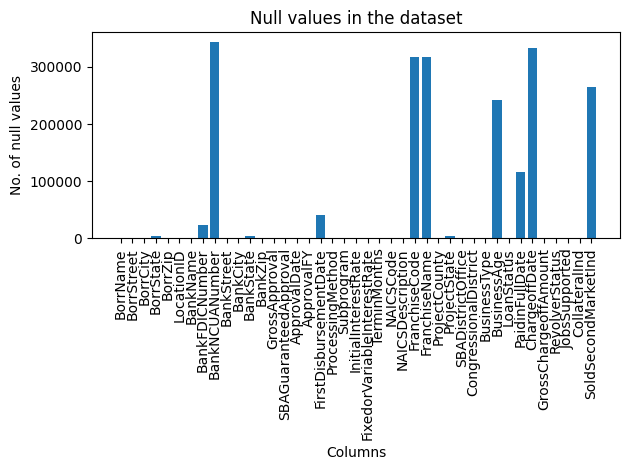

In [5]:
import matplotlib.pyplot as plt

# Null values in each column
nulls = df.isna().sum()
plt.figure(clear=True)
plt.bar(nulls.index, nulls)
plt.title("Null values in the dataset")
plt.tick_params(axis='x', labelrotation=90)
plt.xlabel("Columns")
plt.ylabel("No. of null values")
plt.tight_layout()
plt.show()

In [6]:
# Dropping the columns which have more than 50% of null values
df = df.drop(columns=['BankNCUANumber', 'FranchiseCode', 'FranchiseName'])
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns\n')

The dataset has 354270 rows and 38 columns



### Handling Duplicate Rows and Redundant columns

In [7]:
# dropping duplicate rows
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates().reset_index(drop=True)
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns\n')

Number of duplicate rows: 431
The dataset has 353839 rows and 38 columns



In [8]:
# Dropping irrelevant columns and redundant columns
df = df.drop(columns=['BorrStreet', 'BorrCity', 'BankStreet', 'BankCity'])
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns\n')

The dataset has 353839 rows and 34 columns



## Data Distribution

### Gross Approval Amount

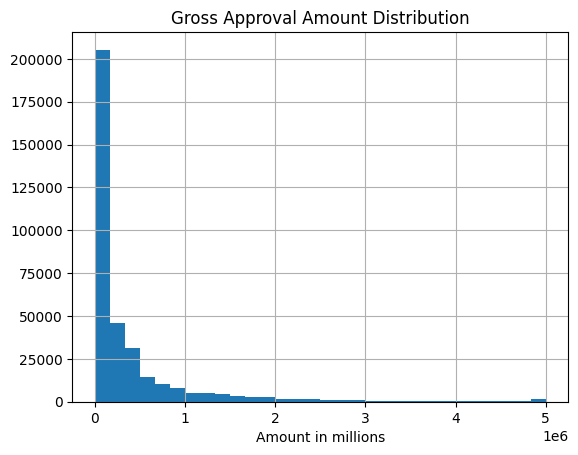

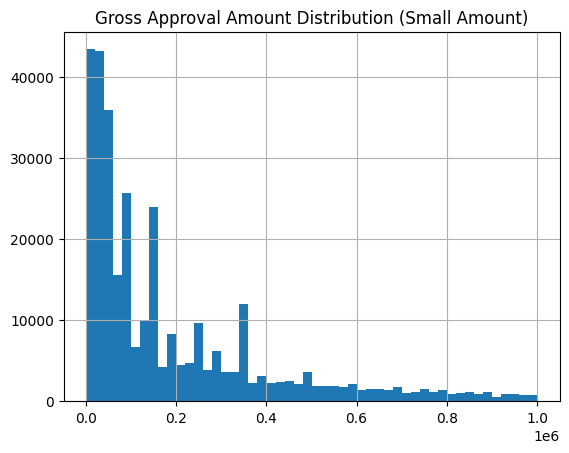

In [ ]:
# Distribution of Gross Approval Amount and SBA Guaranteed Approval Amount
df['GrossApproval'].hist(bins = 30)
plt.title("Gross Approval Amount Distribution")
plt.xlabel("Amount in millions")
plt.show()

df['GrossApproval'][df['GrossApproval'] < 1000000].hist(bins=50)
plt.title("Gross Approval Amount Distribution (Small Amount)")
plt.xlabel("Amount in millions")
plt.show()

# df['SBAGuaranteedApproval'].hist(bins=30)
# plt.title("SBA Guaranteed Approval Amount Distribution")
# plt.xlabel("Amount in millions")
# plt.show()

# df['SBAGuaranteedApproval'][df['SBAGuaranteedApproval'] < 1000000].hist(bins=50)
# plt.title("SBA Guaranteed Approval Amount Distribution")
# plt.xlabel("Amount in millions")
# plt.show()

### Loan Status

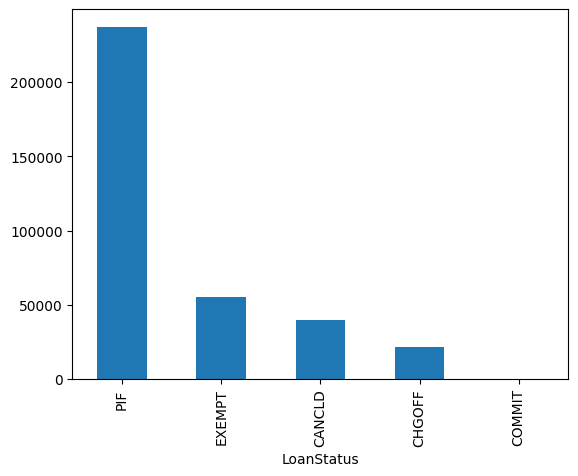

In [ ]:
# Loan Status distribution
df['LoanStatus'].value_counts().plot.bar()
plt.show()


### Gross Charged Off Amount

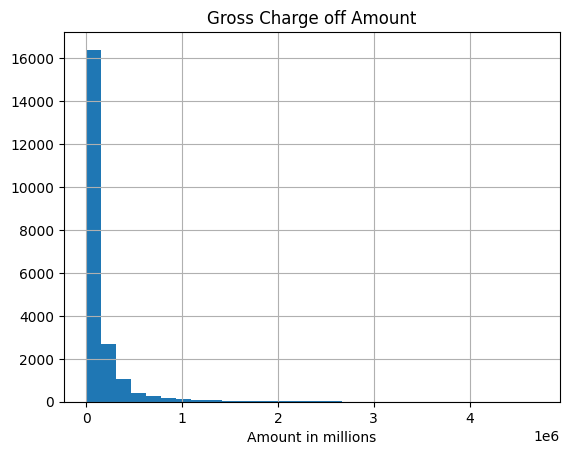

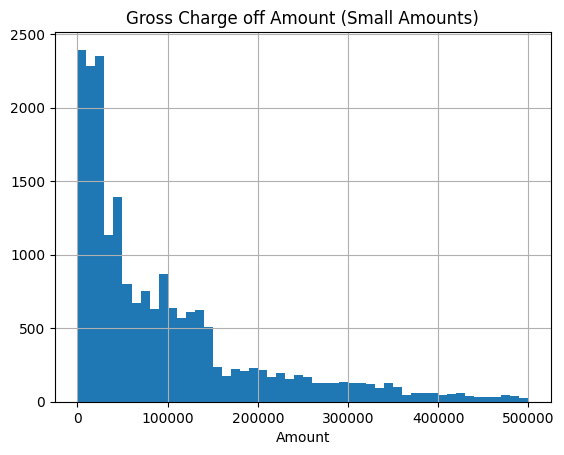

In [76]:
df['GrossChargeoffAmount'][df['GrossChargeoffAmount'] > 0].hist(bins=30)
plt.title("Gross Charge off Amount")
plt.xlabel("Amount in millions")
plt.show()

df['GrossChargeoffAmount'][(df['GrossChargeoffAmount'] <= 500000) & (df['GrossChargeoffAmount'] > 0)].hist(bins=50)
plt.title("Gross Charge off Amount (Small Amounts)")
plt.xlabel("Amount")
plt.show()

### Business Types

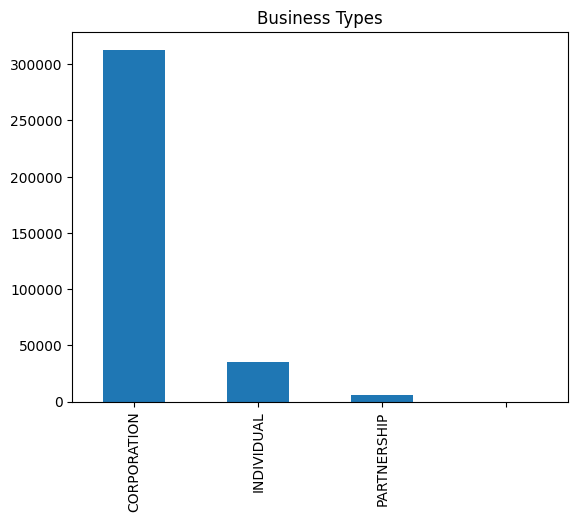

In [78]:
df['BusinessType'].value_counts().plot.bar()
plt.title("Business Types")
plt.xlabel(None)
plt.show()

### Interest Rate Types

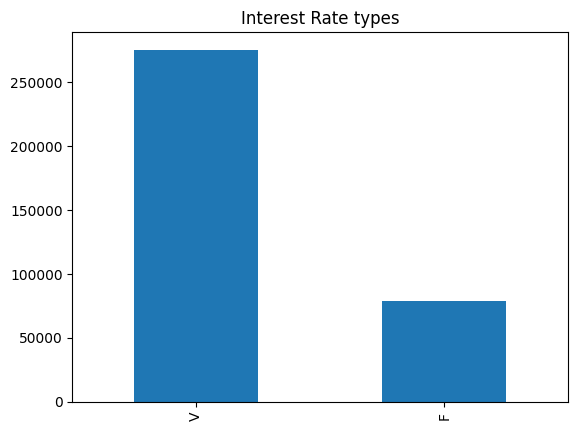

In [98]:
# Number of fixed and variable interest rates
df['FixedorVariableInterestRate'].value_counts().plot.bar()
plt.title('Interest Rate types')
plt.xlabel(None)
plt.show()

### Demographic Distribution of Banks, Borrowers and Project

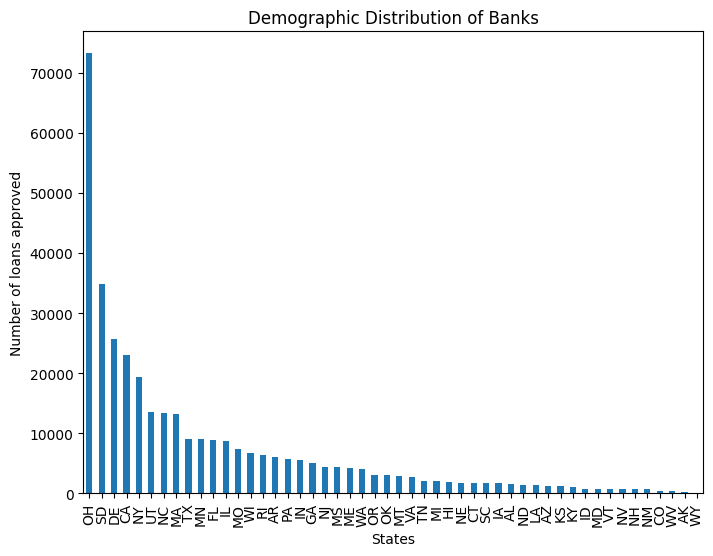

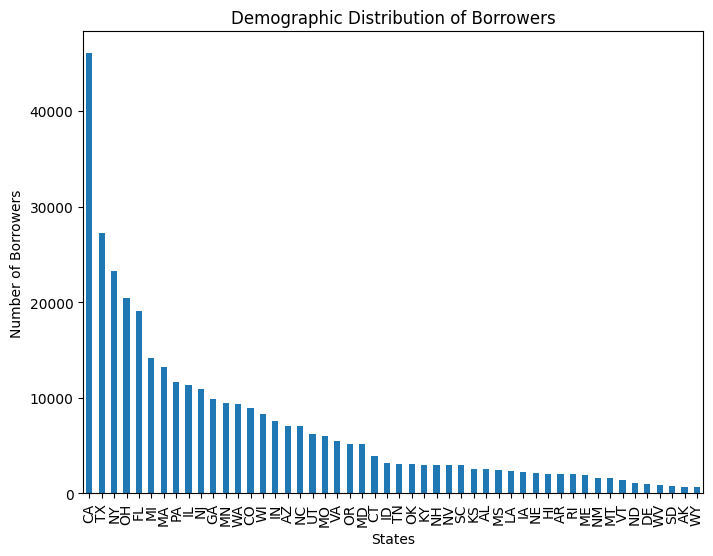

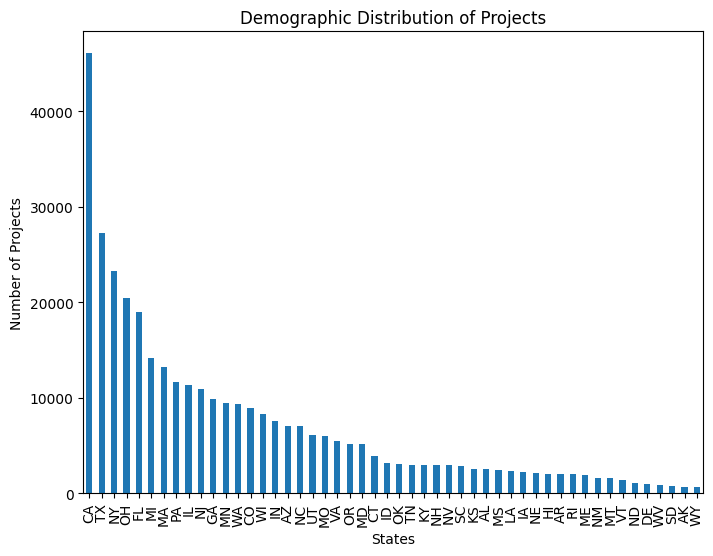

In [84]:
# Distribution of Banks
df['BankState'].value_counts().plot.bar(figsize = (8,6))
plt.title("Demographic Distribution of Banks")
plt.xlabel('States')
plt.ylabel('Number of loans approved')
plt.show()

# Distribution of Borrowers
df['BorrState'].value_counts().plot.bar(figsize=(8, 6))
plt.title("Demographic Distribution of Borrowers")
plt.xlabel('States')
plt.ylabel('Number of Borrowers')
plt.show()

# Distribution of Projects
df['ProjectState'].value_counts().plot.bar(figsize=(8, 6))
plt.title("Demographic Distribution of Projects")
plt.xlabel('States')
plt.ylabel('Number of Projects')
plt.show()

## Relationships & Trends in data

### Trends over Time

   ApprovalFY  ChargeoffPercentage  GrossApproval(Billions)  \
0        2014             2.439484                19.142368   
1        2015             2.537718                23.497555   
2        2016             2.472429                24.082475   
3        2017             2.532709                25.412957   
4        2018             2.282036                25.357418   
5        2019             1.725867                23.168008   

   GrossChargeoffAmount(Millions)  
0                      466.974929  
1                      596.301679  
2                      595.421974  
3                      643.636321  
4                      578.665304  
5                      399.849107   




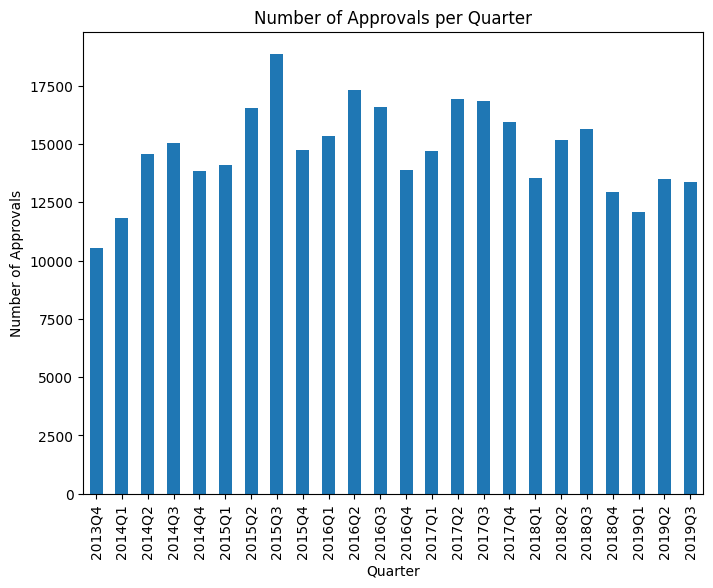

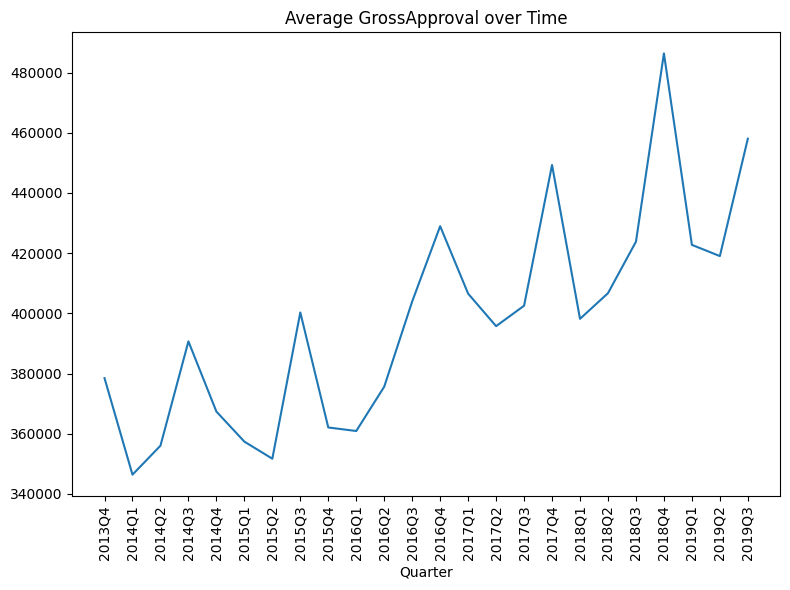

<Figure size 640x480 with 0 Axes>

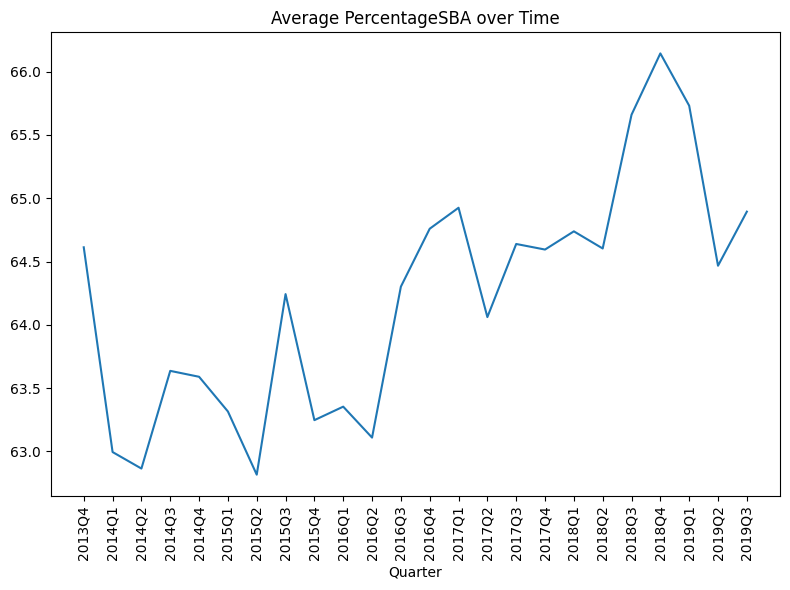

<Figure size 640x480 with 0 Axes>

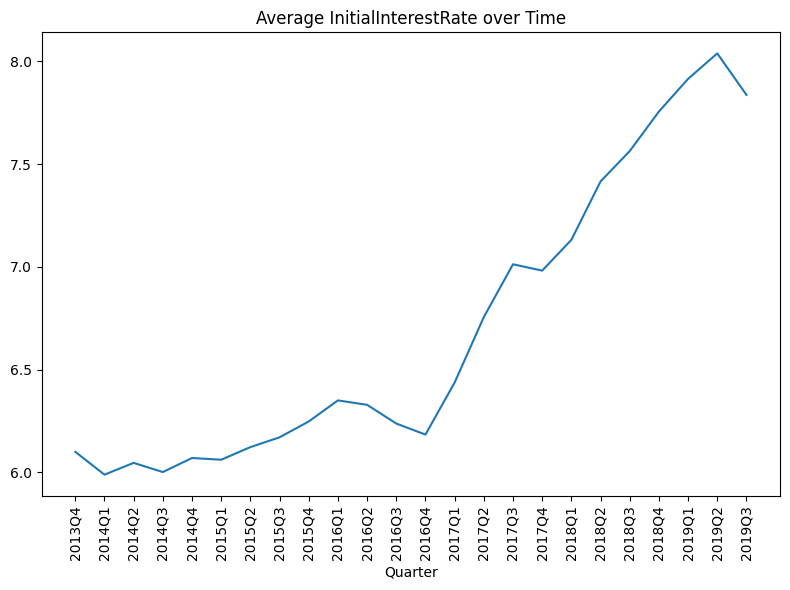

<Figure size 640x480 with 0 Axes>

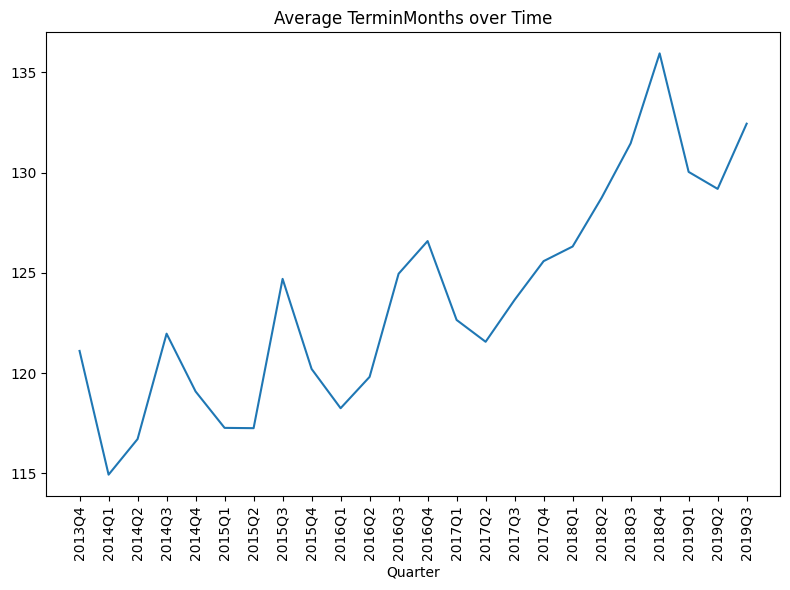

<Figure size 640x480 with 0 Axes>

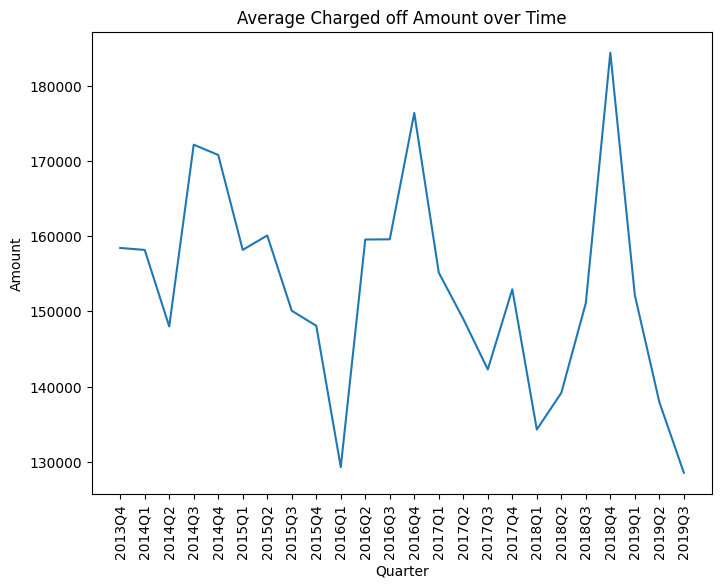

In [124]:
# Metrics per Year
Tot_per_yr = df.groupby('ApprovalFY')[
    ['GrossApproval', 'GrossChargeoffAmount']].sum().reset_index()
Tot_per_yr['ChargeoffPercentage'] = (
    Tot_per_yr['GrossChargeoffAmount']/Tot_per_yr['GrossApproval'])*100
Tot_per_yr['GrossApproval(Billions)'] = Tot_per_yr['GrossApproval']/1000000000
Tot_per_yr['GrossChargeoffAmount(Millions)'] = Tot_per_yr['GrossChargeoffAmount']/1000000
Tot_per_yr = Tot_per_yr.drop(columns=['GrossApproval', 'GrossChargeoffAmount'])
print(Tot_per_yr,'\n\n')

# Number of Approvals over time
df['QuarterYear'] = df['ApprovalDate'].dt.to_period('Q').astype(str)
df['QuarterYear'].value_counts().sort_index().plot.bar(figsize=(8,6))
plt.title('Number of Approvals per Quarter')
plt.xlabel('Quarter')
plt.ylabel("Number of Approvals")
plt.show()

# Average of metrics over time
df['PercentageSBA'] = (df['SBAGuaranteedApproval'] / df['GrossApproval']) * 100
quarterly_avg = df.groupby('QuarterYear')[['GrossApproval', 'PercentageSBA', 'InitialInterestRate', 'TerminMonths']].mean().reset_index()
for col in quarterly_avg.columns[1:]:
    plt.figure(figsize=(8, 6))
    plt.plot(quarterly_avg['QuarterYear'], quarterly_avg[col])
    plt.title(f'Average {col} over Time')
    plt.xlabel('Quarter')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    plt.figure(clear=True)

chgoff_avg = df[df['GrossChargeoffAmount']>0].groupby('QuarterYear')[
    'GrossChargeoffAmount'].mean().reset_index()
plt.figure(figsize=(8, 6))
plt.plot(chgoff_avg['QuarterYear'], chgoff_avg['GrossChargeoffAmount'])
plt.title('Average Charged off Amount over Time')
plt.xlabel('Quarter')
plt.ylabel('Amount')
plt.xticks(rotation= 90)
plt.show()

228120
